In [2]:
%matplotlib inline
import pandas as pd

In [3]:
df = pd.read_csv('data/compras_df_enriched.csv')

# 1 modelo supervisado

# arreglando nulls
lo haremos en 3 pasos:
- usamos una lista que contiene el tipo de datos de cada columna 
- si el typo es "object" la columna es categorica entonces: 
    * llenamos nulos con la moda 
    * hacemos encoding de variables categoricas osea convertimos variables categoricas a numeros. 
- si no es typo "object" la columna es numerica entonces:
    * llenamos nulos con la mediana 
ahora tenemos un dataset con puras variables numericas y sin datos nulos, listos para usarse en un modelo de ML.

si quieres como saber las etiqeutas dfe encoding: 
https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes

    

In [4]:
data = df.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        # llenamos null categoricos con la moda 
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode()) 
        # asignamos typo "catecory" | .cat.code hace encodign de variables categoricas
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes 
    else:
        #llenamos null numericos con la mediana 
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [5]:
data.head(2)

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,YEAR,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKEDIN_SITE
0,110152,161,167,1388,130,780,1,1019110.0,8,14911.8,2,11,12,2020,13,881659.731797,True
1,110152,161,167,1389,135,845,1,1019110.0,8,2528.8,2,11,12,2020,13,881659.731797,True


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

In [8]:
# eliminamos variable a predcir 
y = data.pop('IMPORTE')
X = data.copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)

In [11]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [12]:
# r2 escore es muy utilizado en vars categoricas 
from sklearn.metrics import r2_score

In [13]:
r2_score(y_test, clf.predict(X_test))

0.18642706972180811

# 2 modelo no supervisado o de clustering para texto
la base de este analisis sera entender el uso de la libreria gensim la cual sirve para NLP. en resumen lo que haremos sera: 
1. crear una lista de la palabras unicas presentes en "BENEFICIARIO"
2. limpiar la lista de palabras no utiles 
3. usando la lista creamos un dictionary gensim el cual asigna un indice unico por cada palabra d ela lista.
4. pasamos el texto de cada "BENEFICIARIO" a formato bow, esto quiere decir a un fomato que indicque el indice de la palabra y cuantas veces aparecio 
5. creamos un modelo gensim el cual a partir de bow clusterize el texto contenido en "BENEFICIARIO"
6. guardamos el dato del cluster en una nueva columna CLUSTER_NAME

In [14]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [15]:
# esta fucnion servira para limpiar un texto de stopwords(palabras conectivas sin valor de analisis)
def preprocess(text):
    result = []
    for token in text.split(): # convertimos el parrafo en una lista de palabras
        if token not in stopwords.words('spanish') and len(token)>4: # limpiamos las que esten en stopwords y con tamaño menor a 4
            result.append(token)
    return result

In [17]:
# creremos una lista de beneficiarios pasados por la funcion de limpieza
process_business = [preprocess(x) for x in list(df['BENEFICIARIO'].unique())]

el metodo gensim.corpora.Dictionary nos permite asignar un ID unico por cada palabra de una lista

In [18]:
dictionary = gensim.corpora.Dictionary(process_business)

In [28]:
print(len(dictionary))
list(dictionary.items())[:5]

578


[(0, 'ANAHUAC,S.A.'),
 (1, 'LLANTAS'),
 (2, 'SERNA'),
 (3, 'SERVICIOS'),
 (4, 'EQUIPO,')]

In [42]:
dictionary.filter_extremes(no_below=1, no_above=0.5) # quitar los que aparecen una vez, y si son mas que el 50% de los datos 
print(len(dictionary))

578


In [40]:
df['BENEFICIARIO'].unique()[0]

'LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.'

### gensim.corpora.Dictionary.doc2bow
Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count)

ejemplo: 

dictionary = 

[(0, 'ANAHUAC,S.A.'),
 (1, 'LLANTAS'),
 (2, 'SERNA'),
 (3, 'SERVICIOS'),
 (4, 'EQUIPO,')]

 - con este diccionario pasaremos el siguiente texto: 
 
 'LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.'

 - al formato:

 [(0, 1), (1, 1), (2, 1), (3, 1)]

 que indica que la palabra con indice 0 aparece 1 sola vez en el texto 


In [45]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]
print(bow_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1)]


In [46]:
# creamos el modelo 
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

In [47]:
for idx, type_business in lda_model.print_topics(2):
    print('Topic:{} Words:{}'.format(idx, type_business))
# esto nos mostrara las palabras pertenecientes a un tema (cluster)

Topic:4 Words:0.031*"CONSTRUCTORA" + 0.018*"CONSTRUCCIONES" + 0.018*"MEXICO," + 0.010*"NUEVO" + 0.010*"RAMIREZ" + 0.010*"SEGUROS" + 0.010*"INTEGRACION" + 0.010*"SEBASTIAN," + 0.010*"ARRENDADORA" + 0.010*"GRUPO"
Topic:0 Words:0.010*"DESARROLLOS" + 0.010*"GARZA" + 0.010*"GUERRERO" + 0.010*"INSTITUTO" + 0.010*"SALAZAR" + 0.010*"ADRIANA" + 0.010*"BANCO" + 0.010*"URBANIZACIONES" + 0.010*"IGNACIO" + 0.010*"JESUS"


In [48]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1])[0]

In [50]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(df['BENEFICIARIO'].unique()))}

In [51]:
df['CLUSTER_NAME'] = df['BENEFICIARIO'].apply(lambda x: business_cluster[x])

<AxesSubplot:xlabel='CLUSTER_NAME'>

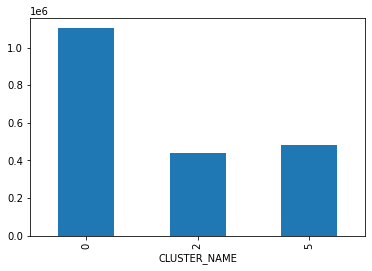

In [52]:
df.groupby('CLUSTER_NAME')['IMPORTE'].mean().plot.bar()
# en esta grafica podemos ver el importe medio que ejecuto cada cluster

# modelo no supervisado de anomalías en cuanto a importes
en resumen usaremos una distribucion gaussiana y usaremos la funcion de distribucion acumulada para encontrar IMPORTES RAROS o outliers.   
si recordamos las clases de estadistica, la distribucion gausiana es una funcion que nos ordena las datos diciendonos la probabilidad de que un dato especifico aparezca.   
En este caso usaremos CDF ver mas abajo 

In [53]:
import numpy as np
from scipy.stats import norm

## CDF (cumulative distribution function)
tells us the probability that a random variable takes on a value less than or equal to some value.
nos dice la probabilidad de que una variable random tome un valor menor o igual a el valor probado. 
1. definimos la funcion de la curva de distribucion nornal : 
    - podemos pasar los datos en el fit o
    - definirla a partir de la mean y std de los datos 
2. calculamos el cdf para cada valor de importe.

In [57]:
params = norm.fit(df['IMPORTE'])
params # regresa (mean, std) compruebalo usando: df['IMPORTE'].std()

(626317.9473441559, 4665396.47441213)

In [64]:
# calculamos el cdf para cada valor de importe
df['PROB_TOTAL'] = [norm(params[0], params[1]).cdf(x) for x in df['IMPORTE']]

para entender lo que sucedio vamos a graficar la probabilidad para cada valor de importe. 

siendo x el valor de importe podemos decir que "y" es la probabilidad de que un valor aleatorio se menor o igual a x. 

por ejemplo vemos 2 puntos con IMPORTE = .8*10^8 =80,000,000 con un valor de cdf = 0.999, esto indica:  
 <b>"hay una probabilidad de 99.9% de que una nuevo registro de IMPORTE sea menor o igual a 80 millones" </b>


viendo la grafica podemos vr otras cosas:
- la distribucion esta sesgada a la derecha lo que quiere decir que tenemos la mayor parte de los datos en IMPORTES bajos concretamente menores a 10 millones

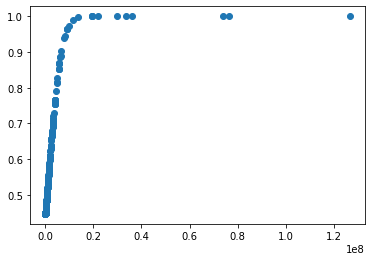

In [69]:
import matplotlib.pyplot as plt
plt.scatter(df['IMPORTE'],df['PROB_TOTAL'])
plt.show()

en base a lo anterior podriamos ver los datos atipicos de gastos altos plateando lo siguiente:  
"cuales son los registros de importe que tienen un 5% la probabilidad de aparecer"   
en otras palabras estos son los importes RAROS

In [76]:
len(df[df['PROB_TOTAL']> .95])# numero de importes raros  

16

dado que la columna SHEET contiene el sector donde se realizo el pago, podemos crear un diccionario que guarde un modelo cdf para cada sector.

In [80]:
models_sheet={}
for sheet in list(df['SHEET'].unique()):
    sheet_compras = df[df['SHEET'] == sheet]
    params = norm.fit(sheet_compras['IMPORTE'])
    models_sheet[sheet] = norm(params[0], params[1])
list(models_sheet.items())[:2]

[('GASTOS VARIOS',
  <scipy.stats._distn_infrastructure.rv_frozen at 0x2a9e1826c10>),
 ('CONTRATISTAS Y FDO FED',
  <scipy.stats._distn_infrastructure.rv_frozen at 0x2a9e174e040>)]

In [82]:
# calculamos el cdf de IMPORTE para cada fila dependiendo el SHEET, lo guardamos en una nueva columna
sheet_prob = []
for i, row in df.iterrows():
    sheet_prob.append(models_sheet[row['SHEET']].cdf(row['IMPORTE']))
df['PROB_SHEET'] = sheet_prob

c:\Users\Panda\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


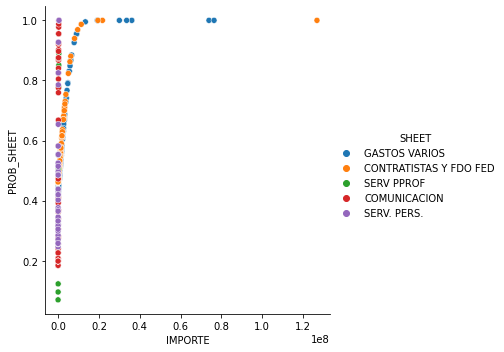

In [88]:
import seaborn as sns 
sns.relplot(df['IMPORTE'],df['PROB_SHEET'], hue=df['SHEET'])
plt.show()

ahora tenemos una distribucion mas exacta que crreamos una curva de distribucion para cada sector.   
vemos que en realidad hay 24 IMPORTES RAROS

In [89]:
len(df[df['PROB_SHEET']>0.95])

24


# Formulando conclusiones

donde encontramos concluciones: 
* Plantear la tendencia central
* Hay historias en los outeliers
* Esfuerzate en contestar la pregunta original
* Si tu enfoque cambio, documentalo.